# Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import Pipeline


from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

# 1. Подготовка

#### Посмотрим на данные

In [2]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Пропусков нет, формат данных корректный.

Посмотрим на стастистические показатели

In [5]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Посмотрим на распределение

array([[<AxesSubplot:title={'center':'num_orders'}>]], dtype=object)

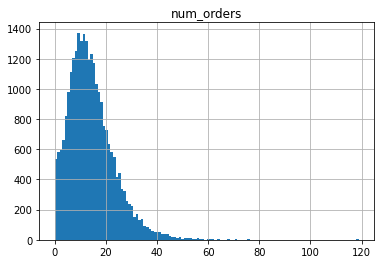

In [6]:
data.hist(bins=120)

In [7]:
len(data[data['num_orders'] > 58])

42

Данные выглядят логнормально, без пропусков. Есть выбросы, но думаю, им есть объяснение и пока не стоит их трогать.  
Отсортируем данные по времени и сделаем ресемплирование по одному часу.

In [8]:
# Сортировка и ресемплирование
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [9]:
# Проверка min и max значения
data.index.min(), data.index.max()

(Timestamp('2018-03-01 00:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

Проверим на монотонность:
    

In [10]:
data.index.is_monotonic

True

# 2. Анализ

Посмотрим на сезонность, тренд и шум в данных

<AxesSubplot:title={'center':'Data'}, xlabel='datetime'>

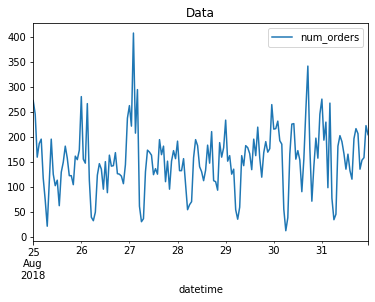

In [11]:
# Посмтроим график последней недели
data.tail(24*7).plot(title='Data')

In [12]:
# Проведем декомпозицию
decomposed = seasonal_decompose(data)

<AxesSubplot:title={'center':'Trend'}, xlabel='datetime'>

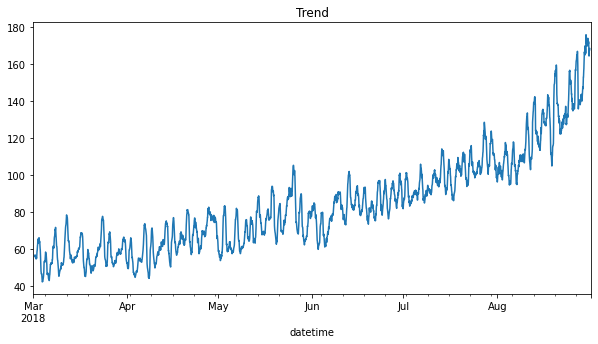

In [13]:
# Построим график тренда
plt.figure(figsize=(10,5))
decomposed.trend.plot(ax=plt.gca(), title='Trend')

#### Виден восходящий тренд    
Посмотрим на сезонность в последней неделе последнего месяца наблюдений, т.к. промежуток семплирования слишком мал(1 час), на всем датасете график получается слишком плотным и выглядит спрошлным прямоугольником.

<AxesSubplot:title={'center':'Seasonal'}, xlabel='datetime'>

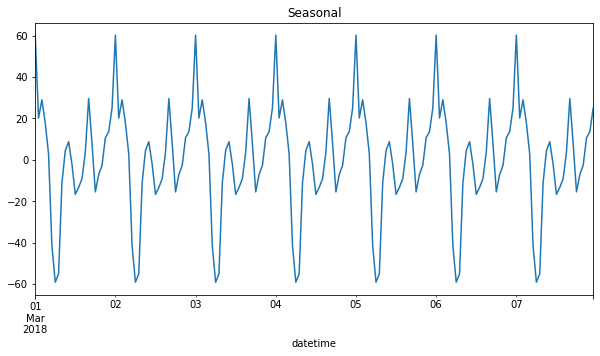

In [14]:
# Построим график сезонности
plt.figure(figsize=(10,5))
decomposed.seasonal.head(24*7).plot(ax=plt.gca(), title='Seasonal')

Видна сезонность в течение дня.  
Посмотрим на шум

<AxesSubplot:title={'center':'Residuals'}, xlabel='datetime'>

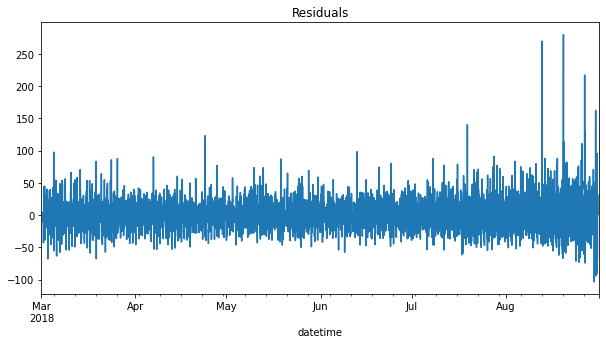

In [15]:
# Построим график шума
plt.figure(figsize=(10,5))
decomposed.resid.plot(ax=plt.gca(), title ='Residuals')

Шум линейный на всём датасете, следовательно это какие-то постоянные внешние факторы

# 3. Обучение

1. Напишем функию для метрики
2. Напишем функцию для создания признаков (для применения в поиске по сетке). В качестве новых признаков будем использовать отдельно год, месяц, день, час, номер дня в неделе, скользящее среднее
3. Разобьем данные на трейн и тест
4. Проверим несколько моделей поиском по сетке: LinearRegression,Ridge и RandomForest  
5. Выберем лучшую и проверим на тесте

In [16]:
#Зададим RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

In [17]:
# Функция для генерации фичей, делаем копию датафрейма, чтобы не изменять исходного
def make_features(data, max_lag, rolling_mean_size):
    data_1 = data.copy()
    # Со
    data_1['year'] = data_1.index.year
    data_1['month'] = data_1.index.month
    data_1['day'] = data_1.index.day
    data_1['hour'] = data_1.index.hour
    data_1['dayofweek'] = data_1.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_1['lag_{}'.format(lag)] = data_1['num_orders'].shift(lag)

    data_1['rolling_mean'] = data_1['num_orders'].shift().rolling(rolling_mean_size).mean()
    data_1 = data_1.dropna()
    return data_1

Напишем пайплайн и сделаем поиск гиперпараметров по сетке

In [18]:
pipe = Pipeline([('model', LinearRegression())])

params = ({'model':[LinearRegression()]},
          
          {'model':[Ridge(random_state = 12345)],
           'model__alpha': np.arange(0.4, 1.1, 0.3),
           'model__max_iter': np.arange(500, 1501, 500)},
          
          {'model':[RandomForestRegressor(random_state = 12345)],
           'model__n_estimators': np.arange(50,151,50),
           'model__max_depth': np.arange(200, 1201, 500)}
)

cv = TimeSeriesSplit(n_splits=3)

In [19]:
%%time

# зададим дефолное значение RMSE и будем перезаписывать его лучшим (чтобы отслеживать лучшую модель)
RMSE = 100

# Найдем модель с лучшими параметрами
for i in range(1,12,5):
    for j in range(1,12,5):
        # Для каждого параметра будем создавать отдельные датасеты

        data_1 = make_features(data, i, j)
        X = data_1.drop('num_orders', axis=1)
        y = data_1['num_orders']
        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, 
                                                            test_size=0.2,random_state=12345)
        X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, shuffle=False, 
                                                            test_size=0.5,random_state=12345)
        # Создадим и обучим grid
        grid = GridSearchCV(pipe, param_grid=params, cv=cv, verbose=False, n_jobs=-1)
        grid.fit(X_train, y_train)
    
        # Запишем лучшую модель среди текущего поиска  
        model = grid.best_estimator_
        pred_val = model.predict(X_valid)
        RMSE_actual = root_mean_squared_error(y_valid, pred_val)
        # Сравним модель с предыдущими параметрами, если текущая модель лучше всех предыдущих - перезапишем лучшую модель
        if RMSE_actual < RMSE:
            RMSE = RMSE_actual
            best_model = model
            best_params = [i,j]

Wall time: 1min 51s


In [20]:
print('RMSE на тестовой выборке:', RMSE)
print('\nЛучшая модель:', best_model)
print('\nЛучшие параметры для генерации фичей:', best_params)

RMSE на тестовой выборке: 31.83598628323399

Лучшая модель: Pipeline(steps=[('model',
                 RandomForestRegressor(max_depth=200, n_estimators=150,
                                       random_state=12345))])

Лучшие параметры для генерации фичей: [11, 11]


Лучшей моделью оказался случайный лес

# 4. Тестирование

Протестируем всё на лучших параметрах и исходном датасете

In [21]:
# Сгенерируем признаки
data = make_features(data, *best_params)
# Созадим датасеты для обучения и теста
X = data.drop('num_orders', axis=1)
y = data['num_orders']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, 
                                                    test_size=0.1,random_state=12345)

In [22]:
# Обучим модель
best_model.fit(X_train, y_train)

Pipeline(steps=[('model',
                 RandomForestRegressor(max_depth=200, n_estimators=150,
                                       random_state=12345))])

In [23]:
# Сделаем предсказание на тестовой выборке
pred_val = best_model.predict(X_test)

In [24]:
# Оценим качество модели
print("RMSE тестовой выборки: ", root_mean_squared_error(y_test, pred_val))

RMSE тестовой выборки:  43.89164419606898


# Вывод:

Проанализировали модели - лучшей оказался **случайный лес**  
На метрике **RMSE** достигли показателя **43.9**, что отвечает требованиям задачи